<a href="https://colab.research.google.com/github/erwanBellon/2025_ML_EES/blob/main/project/code/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part I: Setup



In [1]:

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Cloning repo and path management
!git clone https://github.com/erwanBellon/2025_ML_EES.git

import os
from pathlib import Path

# Move into the project directory
%cd /content/2025_ML_EES/project/code

# Confirm where we are
print("Current working directory:", Path.cwd())

# Where to save figures or outputs
# Define main project dir (parent of 'code')
PROJECT_ROOT_DIR = Path.cwd().parent       # -> /content/2025_ML_EES/project

# Define OUTPUTS folder at project level (not inside code/)
OUTPUTS_PATH = PROJECT_ROOT_DIR / "outputs"
OUTPUTS_PATH.mkdir(parents=True, exist_ok=True)

print("Outputs will be saved to:", OUTPUTS_PATH)
print("Working directory: ", os.getcwd())

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected.  CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Loading Tensorboard
%load_ext tensorboard

fatal: destination path '2025_ML_EES' already exists and is not an empty directory.
/content/2025_ML_EES/project/code
Current working directory: /content/2025_ML_EES/project/code
Outputs will be saved to: /content/2025_ML_EES/project/outputs
Working directory:  /content/2025_ML_EES/project/code
No GPU was detected.  CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


In [2]:
print(Path.cwd())

/content/2025_ML_EES/project/code


# Part 2: Load files
## 2.1: Load the presences and absences landcover crops

In [3]:
from pathlib import Path
!pip install rasterio
import rasterio
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_datasets as tfds



In [4]:

# ----------------------------
# Load images
# ----------------------------

presences_path = Path("../data/cropped_landcover/presences")
absences_path = Path("../data/cropped_landcover/absences")

def load_images_from_folder(folder):
    tif_files = list(folder.glob("*.tif"))
    images = []
    for tif in tif_files:
        with rasterio.open(tif) as src:
            img = src.read()  # (C, H, W)
            img = np.transpose(img, (1, 2, 0))  # (H, W, C)
            images.append(img.astype(np.float32))
    return np.array(images)

images_pres = load_images_from_folder(presences_path)
images_abs = load_images_from_folder(absences_path)
print(f"Presences: {images_pres.shape}, Absences: {images_abs.shape}")

# ----------------------------
# Build dataset & labels
# ----------------------------

X = np.concatenate([images_pres, images_abs], axis=0)
y = np.concatenate([np.ones(len(images_pres)), np.zeros(len(images_abs))], axis=0).astype(np.int32)

# Train/valid/test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_valid.shape, y_valid.shape)
print("Test shape:", X_test.shape, y_test.shape)

# ----------------------------
# Convert to tf.data.Dataset (same structure as TFDS supervised!)
# ----------------------------

train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set  = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Add `.name` attribute like TFDS
train_set.name = "Training"
valid_set.name = "Validation"
test_set.name  = "Test"

print("\nDataset objects created:")
print(train_set)
print(valid_set)
print(test_set)
print(f"\nAssigned names: {train_set.name}, {valid_set.name}, {test_set.name}")



Presences: (100, 30, 30, 1), Absences: (100, 30, 30, 1)
Train shape: (160, 30, 30, 1) (160,)
Validation shape: (20, 30, 30, 1) (20,)
Test shape: (20, 30, 30, 1) (20,)

Dataset objects created:
<_TensorSliceDataset element_spec=(TensorSpec(shape=(30, 30, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
<_TensorSliceDataset element_spec=(TensorSpec(shape=(30, 30, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
<_TensorSliceDataset element_spec=(TensorSpec(shape=(30, 30, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

Assigned names: Training, Validation, Test


## 2.2: Data exploration

In [5]:
def dataset_pixel_info(dataset, max_samples=None):

    pixel_values = []
    nan_count = 0
    inf_count = 0
    total_images = 0

    for i, (images, labels) in enumerate(dataset):
        imgs_np = images.numpy()

        # Flatten the batch of images into 1D array
        flat_pixels = imgs_np.ravel()

        # Count NaNs and Infs
        nan_count += np.isnan(flat_pixels).sum()
        inf_count += np.isinf(flat_pixels).sum()

        # Keep only finite values for unique checking
        finite_pixels = flat_pixels[np.isfinite(flat_pixels)]
        pixel_values.extend(finite_pixels)

        total_images += imgs_np.shape[0]
        if max_samples is not None and total_images >= max_samples:
            break

    pixel_values = np.array(pixel_values)
    unique_values = np.unique(pixel_values)

    print(f"Total images checked: {total_images}")
    print(f"NaN pixels: {nan_count}")
    print(f"Inf pixels: {inf_count}")
    print(f"Number of unique finite pixel values: {len(unique_values)}")
    print(f"Some unique pixel values: {unique_values[:20]}{'...' if len(unique_values) > 20 else ''}")

In [7]:
dataset_pixel_info(train_set, max_samples=100)   # check first 100 images
dataset_pixel_info(valid_set)                     # check all validation images
dataset_pixel_info(test_set)                      # check all test images


Total images checked: 120
NaN pixels: 2597
Inf pixels: 0
Number of unique finite pixel values: 1
Some unique pixel values: [1.]
Total images checked: 600
NaN pixels: 16770
Inf pixels: 0
Number of unique finite pixel values: 1
Some unique pixel values: [1.]
Total images checked: 600
NaN pixels: 16732
Inf pixels: 0
Number of unique finite pixel values: 1
Some unique pixel values: [1.]


In [8]:
def dataset_info(dataset):
    # Extract number of samples
    num_samples = dataset.cardinality().numpy()
    print(f"\n{dataset.name} set contains {num_samples} data samples.",
          "Let's visualize some of them...\n")

    # Shuffle dataset and take a few examples
    sample_batch = dataset.shuffle(100).take(5)

    plt.figure(figsize=(10, 6))
    for idx, (img, label) in enumerate(sample_batch):
        plt.subplot(1, 5, idx + 1)
        plt.imshow(img.numpy().astype("uint8"))
        plt.title("Presence" if label.numpy() == 1 else "Absence")
        plt.axis("off")

    plt.show()



Training set contains 160 data samples. Let's visualize some of them...



/tmp/ipython-input-2495662525.py:13: RuntimeWarning: invalid value encountered in cast
  plt.imshow(img.numpy().astype("uint8"))


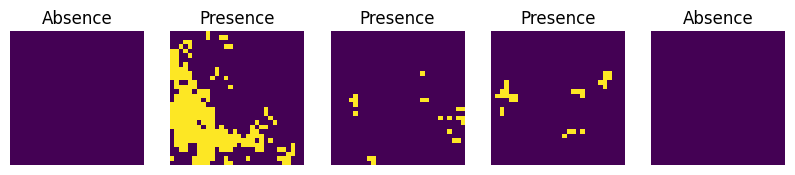


Test set contains 20 data samples. Let's visualize some of them...



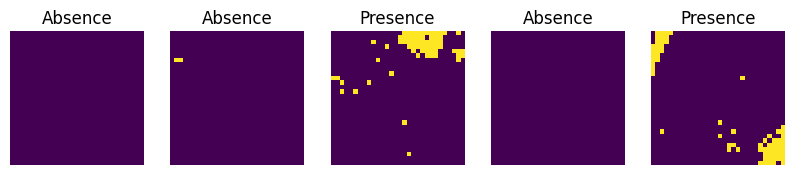


Validation set contains 20 data samples. Let's visualize some of them...



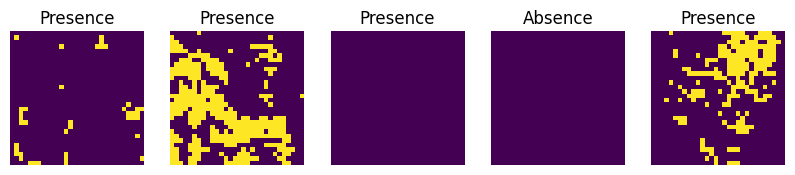

In [9]:
dataset_info(train_set)
dataset_info(test_set)
dataset_info(valid_set)

## 2.3:  Preprocessing function for the images and labels in our dataset. The function should set the image size to 128x128, normalize the pixel values to be between 0 and 1, and one-hot encode the labels

As the aim of the model is to produce suitability map based on landcover (i.e. continuous output values between 0 and 1) I one-hot encore the labels.

In [14]:
def preprocessing_function(image, label):
    # Expected image size
    expected_size = (30, 30)
    num_classes = 2  # presence vs absence

    # Ensure correct dtype
    image = tf.cast(image, tf.float32)


    # Replace NaN values (absence of trees) with 0
    image = tf.where(tf.math.is_nan(image), 0.0, image)

    # Check image size
    img_shape = tf.shape(image)[:2]
    tf.debugging.assert_equal(img_shape, expected_size,
                              message=f"Image is not {expected_size}!")

    # Ensure image has 3 channels (RGB-like)
    if tf.shape(image)[-1] != 3:
        image = tf.image.grayscale_to_rgb(image[..., :1])

    # One-hot encode label
    label = tf.one_hot(tf.cast(label, tf.int32), depth=num_classes)
    label = tf.cast(label, tf.float32)

    return image, label


In [15]:
train = train_set.map(preprocessing_function)
valid = valid_set.map(preprocessing_function)
test = test_set.map(preprocessing_function)

Check that processing went well:

In [16]:
dataset_pixel_info(train, max_samples=100)   # check first 100 images
dataset_pixel_info(valid)                     # check all validation images
dataset_pixel_info(test)                      # check all test images

Total images checked: 120
NaN pixels: 0
Inf pixels: 0
Number of unique finite pixel values: 2
Some unique pixel values: [0. 1.]
Total images checked: 600
NaN pixels: 0
Inf pixels: 0
Number of unique finite pixel values: 2
Some unique pixel values: [0. 1.]
Total images checked: 600
NaN pixels: 0
Inf pixels: 0
Number of unique finite pixel values: 2
Some unique pixel values: [0. 1.]


## 2.4: Batch the data

In [17]:
# Define the batch size
batch_size = 10

train = train.batch(batch_size, drop_remainder=False)
valid = valid.batch(batch_size, drop_remainder=False)
test  = test.batch(batch_size, drop_remainder=False)


In [18]:
for xb, yb in train.take(1):
    print("TRAIN BATCH:", xb.shape, yb.shape)

for xb, yb in valid.take(1):
    print("VALID BATCH:", xb.shape, yb.shape)

for xb, yb in test.take(1):
    print("test BATCH:", xb.shape, yb.shape)


TRAIN BATCH: (10, 30, 30, 3) (10, 2)
VALID BATCH: (10, 30, 30, 3) (10, 2)
test BATCH: (10, 30, 30, 3) (10, 2)


Images batch shape: (10, 30, 30, 3) Labels batch shape: (10, 2)
Max pixel value: 1.0, min pixel value: 0.0
Here's a sample image:

Label: [1. 0.]
Images batch shape: (10, 30, 30, 3) Labels batch shape: (10, 2)
Max pixel value: 1.0, min pixel value: 0.0
Here's a sample image:

Label: [0. 1.]


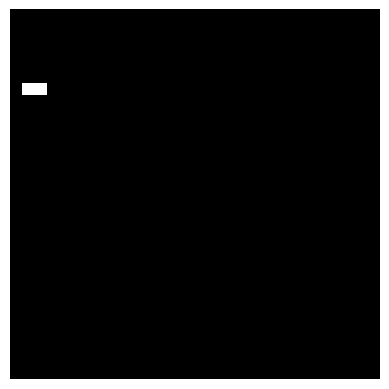

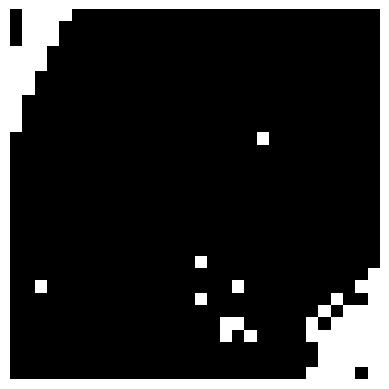

In [27]:
# @title
for images, labels in test.take(3):
    print(f'Images batch shape: {images.shape} Labels batch shape: {labels.shape}')
    print(f'Max pixel value: {images.numpy().max()}, min pixel value: {images.numpy().min()}')
    print("Here's a sample image:\n")
    # Take the thrid image from the batch
    sample_image = images[2]
    sample_label = labels[2]

    fig, ax = plt.subplots()
    ax.axis('off')
    ax.imshow(sample_image)

    print("Label:", sample_label.numpy())
